In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
# === Load data ===


notebook_dir = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
project_root = notebook_dir.parent
results_dir = project_root / "data" / "demo_results"

# Load the CSV
df = pd.read_csv(results_dir / "evaluations" / "evaluation_averaged.csv")
# Clean up column names (already lowercase in your data, but keeping for safety)
df.columns = [c.strip().lower() for c in df.columns]

# Filter out base_model if you want to focus on erasure methods only
# Uncomment the next line if you want to exclude base_model from the tables
# df = df[df['erasing_type'] != 'base_model']

def create_pivoted_table(df_subset, title):
    """
    Create a pivoted table with model types as columns and metrics as rows.
    Aggregates across all concepts for each probe-erasing_type combination.
    """
    # Get unique probes in this subset
    probes = sorted(df_subset['probe'].unique())
    
    # Initialize list to store all rows
    all_rows = []
    
    for probe in probes:
        probe_df = df_subset[df_subset['probe'] == probe]
        
        # Group by erasing_type and compute mean metrics across all concepts
        summary = (
            probe_df
            .groupby("erasing_type", dropna=False)
            .agg(
                clip_score=("clip_score", "mean"),
                top1_mean=("classifier_top1_acc", "mean"),
                top5_mean=("classifier_top5_acc", "mean")
            )
        )
        
        # Format probe name for display
        probe_display = probe.replace('probe', '').replace('_', ' ').title()
        if probe_display.endswith(' '):
            probe_display = probe_display.strip()
        
        # Create rows for this probe
        clip_row = {col: np.nan for col in summary.index}
        top1_row = {col: np.nan for col in summary.index}
        top5_row = {col: np.nan for col in summary.index}
        
        for erasing_type in summary.index:
            clip_row[erasing_type] = summary.loc[erasing_type, 'clip_score']
            top1_row[erasing_type] = summary.loc[erasing_type, 'top1_mean']
            top5_row[erasing_type] = summary.loc[erasing_type, 'top5_mean']
        
        all_rows.append((f'{probe_display} - CLIP', clip_row))
        all_rows.append((f'{probe_display} - Top-1 (%)', top1_row))
        all_rows.append((f'{probe_display} - Top-5 (%)', top5_row))
    
    # Create DataFrame from rows
    if all_rows:
        index_names = [row[0] for row in all_rows]
        row_data = [row[1] for row in all_rows]
        
        final_table = pd.DataFrame(row_data, index=index_names)
        
        # Define the desired column order
        desired_order = ['base_model', 'esdx', 'uce', 'stereo', 'rece']
        # Filter to only columns that exist in the table
        existing_cols = [col for col in desired_order if col in final_table.columns]
        # Add any remaining columns not in the desired order (in case there are others)
        other_cols = [col for col in final_table.columns if col not in desired_order]
        final_column_order = existing_cols + other_cols
        
        # Reorder columns
        final_table = final_table[final_column_order]
        
        # Display the table
        print(f"\n{'='*80}")
        print(f"{title}")
        print('='*80)
        
        # Format and print
        formatted_str = final_table.to_string(float_format=lambda x: f'{x:.2f}', na_rep='--')
        print(formatted_str)
        
        return final_table
    else:
        print(f"No data available for {title}")
        return None

def create_combined_pivoted_table(df_subset, title):
    """
    Create a single pivoted table for multiple probes with model types as columns.
    Each probe gets its own section with CLIP, Top-1, and Top-5 metrics.
    """
    # Get unique probes and erasing types
    probes = sorted(df_subset['probe'].unique())
    erasing_types = sorted(df_subset['erasing_type'].unique())
    
    # Define the desired column order
    desired_order = ['base_model', 'esdx', 'uce', 'stereo', 'rece']
    # Filter to only erasing types that exist in the data
    existing_types = [et for et in desired_order if et in erasing_types]
    # Add any remaining erasing types not in the desired order
    other_types = [et for et in erasing_types if et not in desired_order]
    erasing_types = existing_types + other_types
    
    # Initialize the result DataFrame
    result_data = []
    
    for probe in probes:
        probe_df = df_subset[df_subset['probe'] == probe]
        
        # Group by erasing_type and compute mean metrics across all concepts
        summary = (
            probe_df
            .groupby("erasing_type", dropna=False)
            .agg(
                clip_score=("clip_score", "mean"),
                top1_mean=("classifier_top1_acc", "mean"),
                top5_mean=("classifier_top5_acc", "mean"),
                count=("concept", "count")  # Count number of concepts
            )
        )
        
        # Format probe name
        probe_display = probe.replace('probe', '').replace('_', ' ').title()
        if probe_display.endswith(' '):
            probe_display = probe_display.strip()
        # Special handling for specific probe names
        if probe == 'standardpromptprobe':
            probe_display = 'Standard Prompt'
        elif probe == 'textualinversionprobe':
            probe_display = 'Textual Inversion'
        elif probe == 'inpaintingprobe':
            probe_display = 'Inpainting'
        elif probe == 'noisebasedprobe':
            probe_display = 'Noise-based'
        elif probe == 'classifier_guidance':
            probe_display = 'Classifier Guidance'
        elif probe == 'classifier_guidance_noise_based':
            probe_display = 'Classifier Guidance (Noise)'
        
        # Add rows for this probe
        # CLIP Score row
        clip_row = {'Metric': f'{probe_display} - CLIP'}
        for erasing_type in erasing_types:
            if erasing_type in summary.index:
                clip_row[erasing_type] = summary.loc[erasing_type, 'clip_score']
            else:
                clip_row[erasing_type] = np.nan
        result_data.append(clip_row)
        
        # Top-1 Accuracy row
        top1_row = {'Metric': f'{probe_display} - Top-1 (%)'}
        for erasing_type in erasing_types:
            if erasing_type in summary.index:
                top1_row[erasing_type] = summary.loc[erasing_type, 'top1_mean']
            else:
                top1_row[erasing_type] = np.nan
        result_data.append(top1_row)
        
        # Top-5 Accuracy row
        top5_row = {'Metric': f'{probe_display} - Top-5 (%)'}
        for erasing_type in erasing_types:
            if erasing_type in summary.index:
                top5_row[erasing_type] = summary.loc[erasing_type, 'top5_mean']
            else:
                top5_row[erasing_type] = np.nan
        result_data.append(top5_row)
        
        # Add separator row (empty line between probes)
        if probe != probes[-1]:  # Don't add separator after last probe
            result_data.append({'Metric': '', **{et: np.nan for et in erasing_types}})
    
    # Create DataFrame
    final_table = pd.DataFrame(result_data)
    final_table = final_table.set_index('Metric')
    
    # Display the table
    print(f"\n{'='*80}")
    print(f"{title}")
    print('='*80)
    
    # Format and print
    formatted_str = final_table.to_string(float_format=lambda x: f'{x:.2f}' if not pd.isna(x) else '', na_rep='')
    print(formatted_str)
    
    # Also show concept counts for reference
    print(f"\nConcepts included: {df_subset['concept'].nunique()} unique concepts")
    print(f"Erasing types: {', '.join(erasing_types)}")
    
    return final_table


# === Main Execution ===
print("\n" + "="*80)
print("PIVOTED TABLES WITH MODEL TYPES AS COLUMNS")
print("="*80)

# === 1. Standard Prompt + Textual Inversion + Interference ===
group1 = df[df["probe"].isin(["standardpromptprobe", "textualinversionprobe", "interference"])]
table1 = create_combined_pivoted_table(group1, "Table 1: Standard Prompt, Textual Inversion, and Interference Probes")

# === 2. Inpainting / Diffusion Completion ===
group2 = df[df["probe"].isin(["inpaintingprobe", "diffusioncompletionprobe"])]
table2 = create_combined_pivoted_table(group2, "Table 2: Inpainting and Diffusion Completion Probes")

# === 3. Noise-based Probing ===
group3 = df[df["probe"].isin(["noisebasedprobe"])]
table3 = create_combined_pivoted_table(group3, "Table 3: Noise-based Probing")

# === 4. Classifier Guidance (Normal + Noise-based) ===
group4 = df[df["probe"].isin(["classifier_guidance", "classifier_guidance_noise_based"])]
table4 = create_combined_pivoted_table(group4, "Table 4: Classifier Guidance (Normal + Noise-based)")

print("\n" + "="*80)
print("All tables generated successfully!")
print("="*80)


PIVOTED TABLES WITH MODEL TYPES AS COLUMNS

Table 1: Standard Prompt, Textual Inversion, and Interference Probes
                               base_model   esdx    uce  stereo   rece
Metric                                                                
Interference - CLIP                        31.06  31.28   30.35  30.91
Interference - Top-1 (%)                   61.67  62.78   54.26  60.37
Interference - Top-5 (%)                   75.93  76.67   73.15  75.56
                                                                      
Standard Prompt - CLIP              28.72  21.83  22.04   18.93  22.79
Standard Prompt - Top-1 (%)         95.00  21.67  13.33    1.67  31.67
Standard Prompt - Top-5 (%)        100.00  33.33  33.33    1.67  40.00
                                                                      
Textual Inversion - CLIP                   28.60  28.60   25.15  28.76
Textual Inversion - Top-1 (%)              96.67  96.67   41.67  98.33
Textual Inversion - Top-5 (%)     

In [12]:
%config InlineBackend.figure_format = 'jpg'

# Lower DPI and default figure size
plt.rcParams['figure.dpi'] = 75        # smaller resolution


Creating Figure 1: Standard Prompt, Textual Inversion, and Interference


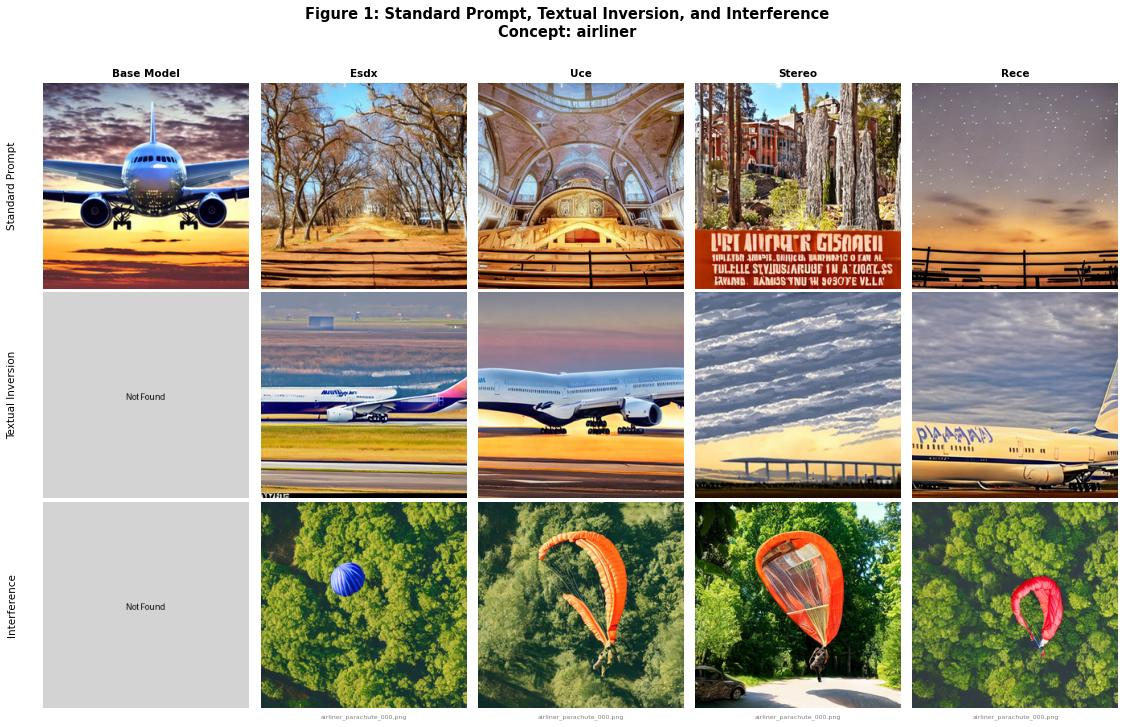

✓ Completed Figure 1: Standard Prompt, Textual Inversion, and Interference

Creating Figure 2: Inpainting and Diffusion Completion


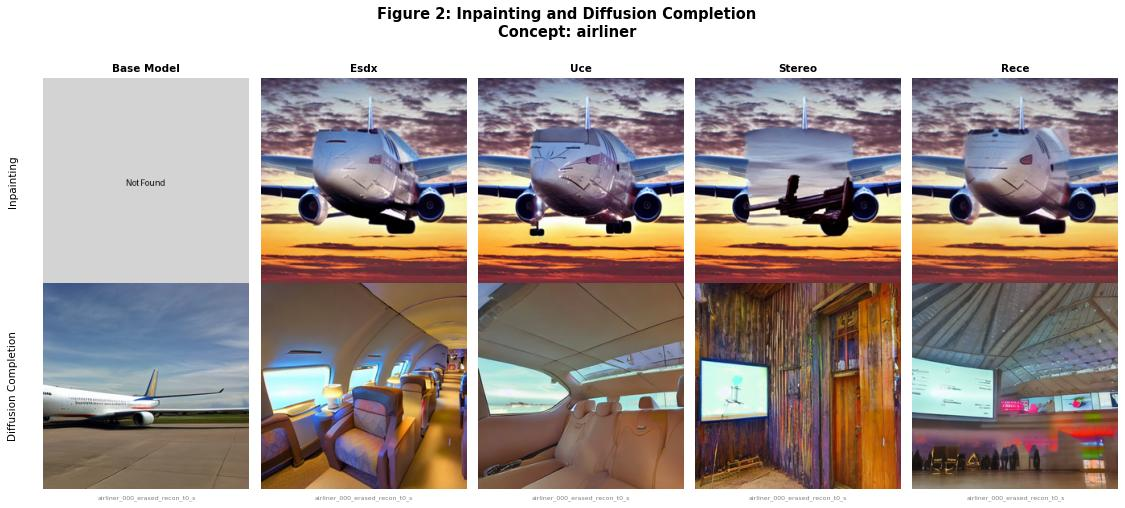

✓ Completed Figure 2: Inpainting and Diffusion Completion

Creating Figure 3: Noise-based Probing


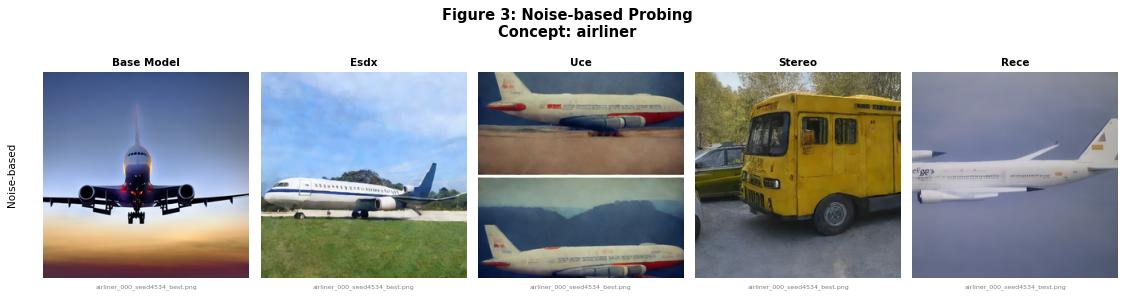

✓ Completed Figure 3: Noise-based Probing

Creating Figure 4: Classifier Guidance


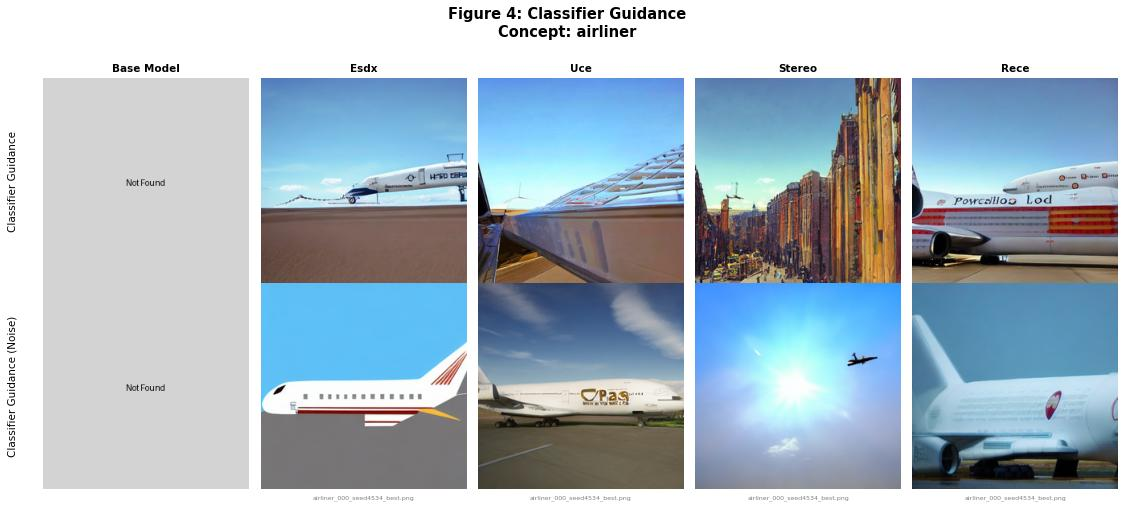

✓ Completed Figure 4: Classifier Guidance


In [13]:
import os
import glob
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Base path to results (relative path for portability)
BASE_PATH = project_root / "data" / "demo_results"

# Define model order (matching tables)
MODEL_ORDER = ['base_model', 'esdx', 'uce', 'stereo', 'rece']

# Define probe groups (matching your 4 tables)
PROBE_GROUPS = {
    'Figure 1: Standard Prompt, Textual Inversion, and Interference': [
        'standardpromptprobe',
        'textualinversionprobe', 
        'interference'
    ],
    'Figure 2: Inpainting and Diffusion Completion': [
        'inpaintingprobe',
        'diffusioncompletionprobe'
    ],
    'Figure 3: Noise-based Probing': [
        'noisebasedprobe'
    ],
    'Figure 4: Classifier Guidance': [
        'classifier_guidance',
        'classifier_guidance_noise_based'
    ]
}

def get_first_image(model, concept, probe, base_path=BASE_PATH):
    """
    Get the first image from a specific model/concept/probe combination.
    Returns the image path or None if not found.
    """
    # Build the path pattern
    folder_path = os.path.join(base_path, model, concept, probe)
    
    # Special path handling for specific probes
    if probe == 'interference':
        folder_path = os.path.join(folder_path, 'parachute')
    elif probe == 'diffusioncompletionprobe':
        folder_path = os.path.join(folder_path, 'erased_recon')
    
    # Look for PNG files in the folder
    pattern = os.path.join(folder_path, "*.png")
    image_files = glob.glob(pattern)
    
    if image_files:
        # Sort to ensure consistent ordering and get first
        image_files.sort()
        return image_files[0]
    
    return None

def load_image_safe(image_path, target_size=(256, 256)):
    """
    Safely load an image, returning a placeholder if not found.
    """
    if image_path and os.path.exists(image_path):
        try:
            img = Image.open(image_path)
            img = img.resize(target_size, Image.Resampling.LANCZOS)
            return img
        except Exception as e:
            print(f"Error loading {image_path}: {e}")
    
    # Return placeholder image if file not found
    placeholder = Image.new('RGB', target_size, color='lightgray')
    draw = ImageDraw.Draw(placeholder)
    text = "Not Found"
    # Simple text positioning (center)
    text_bbox = draw.textbbox((0, 0), text)
    text_width = text_bbox[2] - text_bbox[0]
    text_height = text_bbox[3] - text_bbox[1]
    position = ((target_size[0] - text_width) // 2, (target_size[1] - text_height) // 2)
    draw.text(position, text, fill='black')
    return placeholder

def format_probe_name(probe):
    """
    Format probe name for display.
    """
    name_map = {
        'standardpromptprobe': 'Standard Prompt',
        'textualinversionprobe': 'Textual Inversion',
        'interference': 'Interference',
        'inpaintingprobe': 'Inpainting',
        'diffusioncompletionprobe': 'Diffusion Completion',
        'noisebasedprobe': 'Noise-based',
        'classifier_guidance': 'Classifier Guidance',
        'classifier_guidance_noise_based': 'Classifier Guidance (Noise)'
    }
    return name_map.get(probe, probe.replace('_', ' ').title())

def create_image_grid(figure_name, probes, concept='airliner', base_path=BASE_PATH, save_fig=False, save_path=None):
    """
    Create an image grid for a specific figure/table.
    
    Args:
        figure_name: Name of the figure (e.g., "Figure 1: Standard Prompt...")
        probes: List of probe names to include
        concept: Concept to visualize (default: 'airliner')
        base_path: Base path to the data folder (can be overridden)
        save_fig: Whether to save the figure to disk
        save_path: Path to save the figure (optional)
    
    Returns:
        fig: The matplotlib figure object
    """
    # Number of rows (probes) and columns (models)
    n_rows = len(probes)
    n_cols = len(MODEL_ORDER)
    
    # Create figure with appropriate size
    fig_width = n_cols * 3
    fig_height = n_rows * 3 + 1  # Extra space for titles
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
    
    # Handle single row case
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Set main title
    fig.suptitle(f'{figure_name}\nConcept: {concept}', fontsize=14, fontweight='bold')
    
    # Create the grid
    for row_idx, probe in enumerate(probes):
        for col_idx, model in enumerate(MODEL_ORDER):
            ax = axes[row_idx, col_idx]
            
            # Get and load the image
            image_path = get_first_image(model, concept, probe, base_path)
            img = load_image_safe(image_path)
            
            # Display the image
            ax.imshow(np.array(img))
            ax.axis('off')
            
            # Add column headers (model names) on first row
            if row_idx == 0:
                ax.set_title(model.replace('_', ' ').title(), fontsize=10, fontweight='bold')
            
            # Add row labels (probe names) on first column
            if col_idx == 0:
                ax.text(-0.15, 0.5, format_probe_name(probe), 
                       transform=ax.transAxes, 
                       fontsize=10, 
                       rotation=90, 
                       verticalalignment='center',
                       horizontalalignment='center')
            
            # Add small caption with filename if image exists
            if image_path:
                filename = os.path.basename(image_path)
                ax.text(0.5, -0.05, filename[:30], 
                       transform=ax.transAxes,
                       fontsize=6,
                       horizontalalignment='center',
                       color='gray')
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    
    # Save if requested
    if save_fig and save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    # Display in notebook
    plt.show()
    
    return fig

def create_all_grids(concept='airliner', base_path=BASE_PATH, save_figs=False, output_dir="figures"):
    """
    Create all four figure grids matching the four tables.
    
    Args:
        concept: Concept to visualize (default: 'airliner')
        base_path: Base path to the data folder
        save_figs: Whether to save figures to disk
        output_dir: Directory to save figures (will be created if it doesn't exist)
    
    Returns:
        figures: List of matplotlib figure objects
    """
    figures = []
    
    # Create output directory if saving and it doesn't exist
    if save_figs and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for fig_num, (figure_name, probes) in enumerate(PROBE_GROUPS.items(), 1):
        print(f"\n{'='*80}")
        print(f"Creating {figure_name}")
        print('='*80)
        
        # Create output filename if saving
        save_path = None
        if save_figs:
            save_path = os.path.join(output_dir, f"figure_{fig_num}_{concept}.png")
        
        # Create the grid
        fig = create_image_grid(
            figure_name, 
            probes, 
            concept, 
            base_path,
            save_fig=save_figs,
            save_path=save_path
        )
        
        figures.append(fig)
        print(f"✓ Completed {figure_name}")
    
    return figures

def create_compact_grid(concept='airliner', base_path=BASE_PATH, save_fig=False, output_dir="figures"):
    """
    Create a single large grid showing all probes and models.
    
    Args:
        concept: Concept to visualize
        base_path: Base path to the data folder
        save_fig: Whether to save the figure
        output_dir: Directory to save the figure
    
    Returns:
        fig: The matplotlib figure object
    """
    # Flatten all probes
    all_probes = []
    probe_groups_labels = []
    
    for group_name, probes in PROBE_GROUPS.items():
        group_label = group_name.split(':')[0]  # Get "Figure 1", "Figure 2", etc.
        for probe in probes:
            all_probes.append(probe)
            probe_groups_labels.append(group_label)
    
    n_rows = len(all_probes)
    n_cols = len(MODEL_ORDER)
    
    # Create larger figure
    fig_width = n_cols * 2.5
    fig_height = n_rows * 2.5 + 1
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
    
    # Handle single row case
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Set main title
    fig.suptitle(f'All Probes Comparison - Concept: {concept}', fontsize=16, fontweight='bold')
    
    current_group = None
    
    # Create the grid
    for row_idx, probe in enumerate(all_probes):
        # Add group separator
        if probe_groups_labels[row_idx] != current_group:
            current_group = probe_groups_labels[row_idx]
            # Add a text label for the group
            for col_idx in range(n_cols):
                ax = axes[row_idx, col_idx]
                if col_idx == 0:
                    ax.text(-0.3, 0.5, current_group, 
                           transform=ax.transAxes, 
                           fontsize=9, 
                           fontweight='bold',
                           rotation=90, 
                           verticalalignment='center',
                           horizontalalignment='center',
                           color='blue')
        
        for col_idx, model in enumerate(MODEL_ORDER):
            ax = axes[row_idx, col_idx]
            
            # Get and load the image
            image_path = get_first_image(model, concept, probe, base_path)
            img = load_image_safe(image_path, target_size=(224, 224))
            
            # Display the image
            ax.imshow(np.array(img))
            ax.axis('off')
            
            # Add column headers (model names) on first row
            if row_idx == 0:
                ax.set_title(model.replace('_', ' ').title(), fontsize=10, fontweight='bold')
            
            # Add row labels (probe names)
            if col_idx == 0:
                ax.text(-0.15, 0.5, format_probe_name(probe), 
                       transform=ax.transAxes, 
                       fontsize=8, 
                       rotation=90, 
                       verticalalignment='center',
                       horizontalalignment='center')
    
    # Adjust layout
    plt.tight_layout(rect=[0.02, 0, 1, 0.98])
    
    # Save if requested
    if save_fig:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        save_path = os.path.join(output_dir, f"all_probes_grid_{concept}.png")
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\nSaved compact grid: {save_path}")
    
    # Display in notebook
    plt.show()
    
    return fig

# Example usage in Jupyter notebook
if __name__ == "__main__":
        # This section shows example usage

    # Create all individual grids for a concept
    figures = create_all_grids(concept='airliner', base_path=BASE_PATH)